### Exercise 2: Camera-Based Queue Analysis in an Amusement Park (15 Points + Optional 3 Bonus Points) 


A globally renowned amusement park is aiming to enhance its digital experience. Instead of using traditional floor markers to estimate wait times (e.g., “20 minutes from here”), the park wants to explore a dynamic, AI-supported solution for analyzing queues in real time. 

You have submitted a proposal for a proof of concept (PoC) and have been selected to implement a camera-based queue analysis system. Your task is to estimate the number of people waiting in line using a multi-camera setup. You can assume that all people visible in the footage belong to the queue. However, most queueing areas include bends or corners, so a single camera is not sufficient. The client therefore envisions a multi-camera system, where individuals must not be counted more than once as they move through the field of view. 

Tip: You are encouraged to build on tools and methods discussed in class, such as dlib (e.g. for face-based re-identification) and MediaPipe (e.g. for pose or person tracking). Your choice of approach should be aligned with your assumptions about camera position and visibility (e.g., whether faces are consistently visible).  





<div align="center">
  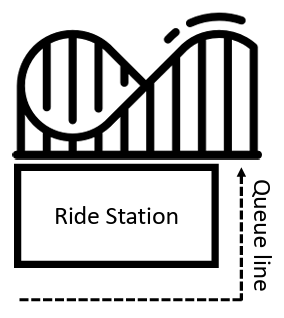
</div>

### Subtask 1: Conceptualize the Camera Setup 

Define your assumptions and setup parameters, such as: 

• camera positions, height, and angles, 

• number of cameras (minimum: 2), 

• visibility conditions (e.g., are faces visible? Is the full body tracked?). 

Reflect on whether your chosen method (face-based or posebased tracking) is applicable to the conditions you assume. You do not need to consider camera resolution at this stage.


-------------------------------------------------------------------------------------------------------------------------

As part of the **proof of concept (PoC)**, we aim to simulate a queue analysis system using a controlled setup with two video streams. While the final deployment in the amusement park may involve a more complex camera infrastructure, this PoC focuses on validating the approach using a minimal and practical configuration. Our objective is to demonstrate accurate person detection and re-identification using readily available tools.


#### Camera Configuration

- **Number of Cameras**:  
  We utilize **2 cameras** strategically positioned to cover the entire queue region, including bends or corners that may obscure visibility in a single-view setup.

- **Camera Positions and Angles**:  
  - **Camera 1**: Mounted at the **start of the queue** at a height of 2.5 meters, angled downward (45°) to monitor people entering the queue.  
  - **Camera 2**: Positioned at a **bend** or near the **end of the queue** to ensure a complementary angle and minimize blind spots.

- **Field of View (FOV)**:  
  Both cameras will have partial **overlap** to enable multi-view re-identification and avoid duplicate counting.

<div align="center">
  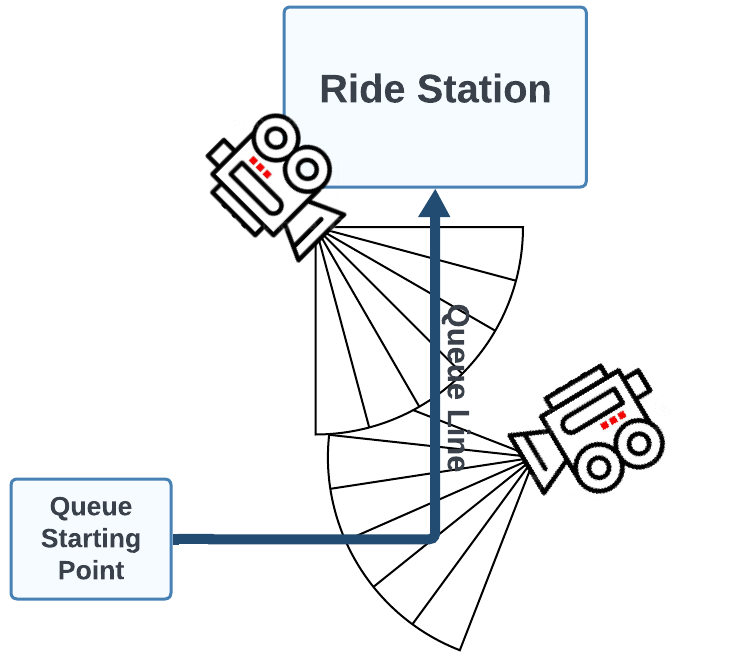
</div>


#### Visibility Conditions

- **Face Visibility**:  
  Faces are **not guaranteed** to be visible consistently due to camera angles and crowding. Therefore, **face-based methods are not applicable**.

- **Body Visibility**:  
  Cameras are positioned such that **full body tracking** is feasible in most cases.



#### Method Justification

- We will use **YOLOv8** for real-time person detection (full-body based).  
- **TorchReID with OSNet** will handle **appearance-based person re-identification** to avoid counting the same individual multiple times across cameras.


------------------------------------------------------------------------------------------

### Subtask 2: Implement Cross-Camera Person Tracking Develop a solution to track people across camera views, ensuring:

• No individual is counted more than once when moving from one camera to another. 

• The current number of people in the queue is continuously displayed or updated. 

You may use any tools discussed during the course or open-source libraries. The core logic and design decisions must be documented and justified. 

------------------------------------------------------------------------------------------------------------------------------------


**1. Detection (YOLOv8)**

- We use YOLOv8 to detect full-body bounding boxes of people in each frame.

- It works in real time and handles occlusions and varying orientations.

**2. Re-Identification (TorchReID + OSNet)**

- For each detected person, we extract embeddings using the OSNet/Resnet model.

- These embeddings are matched across camera views using cosine similarity.

If the similarity with any known person is above a threshold, we do not count them again.

**3. Unique Person Count**

- A list of known embeddings is maintained.

- When a new embedding does not match any previous one (i.e., it's unique), 

- we Count this person.

- Add the embedding to the known list.



##### Real Implementation: 

In [ ]:
#!pip install matplotlib
#!pip install numpy

In [ ]:
#!pip install torchreid
#!pip install gdown

In [1]:
import os
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore")
# Ignore all UserWarnings globally
warnings.filterwarnings("ignore", category=UserWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Device name:", torch.cuda.get_device_name(0))


C:\Softwares\Anaconda\envs\clouds_modeling\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Softwares\Anaconda\envs\clouds_modeling\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Softwares\Anaconda\envs\clouds_modeling\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"



CUDA available: True
Device count: 1
Device name: NVIDIA GeForce RTX 3050 Laptop GPU


In [13]:
import torch
import torchvision.transforms as T
from PIL import Image
import numpy as np
import os
import torchreid

# Load the model
model = torchreid.models.build_model(
    name='resnet18',
    num_classes=7,
    loss='softmax',
    pretrained=True,
    use_gpu=torch.cuda.is_available()
)

#MODELS_TO_TEST = [    'osnet_x1_0',    'mobilenetv2_x1_0',    'resnet50',    'osnet_ain_x1_0']
model.eval()

if torch.cuda.is_available():
    model.cuda()

# Image transformation
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


def get_embedding(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    if torch.cuda.is_available():
        image = image.cuda()
    with torch.no_grad():
        features = model(image)
    return features.cpu().numpy().flatten()

# Compare query to all gallery images
def reid_match(query_dir, gallery_dir, threshold=0.8):
    for query_img in os.listdir(query_dir):
        query_path = os.path.join(query_dir, query_img)
        query_vec = get_embedding(query_path)

        print(f"\n🔍 Matches for: {query_img}")
        for gallery_img in os.listdir(gallery_dir):
            gallery_path = os.path.join(gallery_dir, gallery_img)
            if os.path.isdir(gallery_path):  # 👈 Skip folders
                continue
            gallery_vec = get_embedding(gallery_path)
            sim = np.dot(query_vec, gallery_vec) / (np.linalg.norm(query_vec) * np.linalg.norm(gallery_vec))
            print(f"  {gallery_img} → Cosine Sim: {sim:.5f} → {'✅ SAME' if sim > threshold else '❌ DIFFERENT'}")

# Run
reid_match("query", "gallery")


🔍 Matches for: person_1.png
  person_1.png → Cosine Sim: 0.93009 → ✅ SAME
  person_2.png → Cosine Sim: 0.90701 → ✅ SAME
  person_3.png → Cosine Sim: 0.89382 → ✅ SAME
  person_4.png → Cosine Sim: 0.90274 → ✅ SAME
  person_5.png → Cosine Sim: 0.87712 → ✅ SAME
  person_6.png → Cosine Sim: 0.90964 → ✅ SAME

🔍 Matches for: person_2.png
  person_1.png → Cosine Sim: 0.89544 → ✅ SAME
  person_2.png → Cosine Sim: 0.88694 → ✅ SAME
  person_3.png → Cosine Sim: 0.87700 → ✅ SAME
  person_4.png → Cosine Sim: 0.84818 → ✅ SAME
  person_5.png → Cosine Sim: 0.84105 → ✅ SAME
  person_6.png → Cosine Sim: 0.90663 → ✅ SAME

🔍 Matches for: person_3.png
  person_1.png → Cosine Sim: 0.85424 → ✅ SAME
  person_2.png → Cosine Sim: 0.84187 → ✅ SAME
  person_3.png → Cosine Sim: 0.93458 → ✅ SAME
  person_4.png → Cosine Sim: 0.89613 → ✅ SAME
  person_5.png → Cosine Sim: 0.86184 → ✅ SAME
  person_6.png → Cosine Sim: 0.91190 → ✅ SAME

🔍 Matches for: person_4.png
  person_1.png → Cosine Sim: 0.89971 → ✅ SAME
  person_2

In [28]:
import torch
import torchvision.transforms as T
from PIL import Image
import numpy as np
import os
import torchreid

# -------------------
# 1. Load the ReID model
# -------------------

model = torchreid.models.build_model(
    name='osnet_x1_0',   # <--- Normal OSNet
    num_classes=751,
    loss='softmax',
    pretrained=True,
    use_gpu=torch.cuda.is_available()
)



model.eval()

if torch.cuda.is_available():
    model.cuda()

# -------------------
# 2. Image Transformation
# -------------------

transform = T.Compose([
    T.Resize((256, 128)),    # Resize to ReID standard input
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# -------------------
# 3. Embedding Extraction
# -------------------

def get_embedding(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    if torch.cuda.is_available():
        image = image.cuda()
    with torch.no_grad():
        features = model(image, return_featuremaps=False)  # Extract feature vector
    return features.cpu().numpy().flatten()

# -------------------
# 4. ReID Matching
# -------------------

def reid_match(query_dir, gallery_dir, threshold=0.7):
    for query_img in os.listdir(query_dir):
        query_path = os.path.join(query_dir, query_img)
        query_vec = get_embedding(query_path)

        print(f"\n🔍 Matches for: {query_img}")
        for gallery_img in os.listdir(gallery_dir):
            gallery_path = os.path.join(gallery_dir, gallery_img)
            if os.path.isdir(gallery_path):
                continue
            gallery_vec = get_embedding(gallery_path)
            sim = np.dot(query_vec, gallery_vec) / (np.linalg.norm(query_vec) * np.linalg.norm(gallery_vec))
            print(f"  {gallery_img} → Cosine Sim: {sim:.5f} → {'✅ SAME' if sim > threshold else '❌ DIFFERENT'}")

# -------------------
# 5. Run the matching
# -------------------

reid_match("query", "gallery")


Successfully loaded imagenet pretrained weights from "C:\Users\korin/.cache\torch\checkpoints\osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']

🔍 Matches for: person_1.png
  person_1.png → Cosine Sim: 0.70772 → ✅ SAME
  person_2.png → Cosine Sim: 0.68203 → ❌ DIFFERENT
  person_3.png → Cosine Sim: 0.61905 → ❌ DIFFERENT
  person_4.png → Cosine Sim: 0.66894 → ❌ DIFFERENT
  person_5.png → Cosine Sim: 0.61331 → ❌ DIFFERENT
  person_6.png → Cosine Sim: 0.70895 → ✅ SAME

🔍 Matches for: person_2.png
  person_1.png → Cosine Sim: 0.61090 → ❌ DIFFERENT
  person_2.png → Cosine Sim: 0.74515 → ✅ SAME
  person_3.png → Cosine Sim: 0.57212 → ❌ DIFFERENT
  person_4.png → Cosine Sim: 0.66257 → ❌ DIFFERENT
  person_5.png → Cosine Sim: 0.60352 → ❌ DIFFERENT
  person_6.png → Cosine Sim: 0.70246 → ✅ SAME

🔍 Matches for: person_3.png
  person_1.png → Cosine Sim: 0.60257 → ❌ DIFFERENT
  person_2.png → Cosine Sim: 0.6439

In [31]:
import torch
import torchvision.transforms as T
from PIL import Image
import numpy as np
import os
import torchreid

# -------------------
# 1. Load the ReID model
# -------------------
model = torchreid.models.build_model(
    name='osnet_x1_0',
    num_classes=751,
    loss='softmax',
    pretrained=True,
    use_gpu=torch.cuda.is_available()
)

model.eval()

if torch.cuda.is_available():
    model.cuda()

# -------------------
# 2. Image Transformation
# -------------------
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# -------------------
# 3. Embedding Extraction
# -------------------
def get_embedding(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    if torch.cuda.is_available():
        image = image.cuda()
    with torch.no_grad():
        features = model(image, return_featuremaps=False)
    return features.cpu().numpy().flatten()

# -------------------
# 4. Precompute Gallery Features
# -------------------
def precompute_gallery(gallery_dir):
    gallery_features = {}
    for gallery_img in os.listdir(gallery_dir):
        gallery_path = os.path.join(gallery_dir, gallery_img)
        if os.path.isdir(gallery_path):
            continue
        emb = get_embedding(gallery_path)
        gallery_features[gallery_img] = emb
    return gallery_features

# -------------------
# 5. Faster ReID Matching
# -------------------
def reid_match(query_dir, gallery_features, threshold=0.7):
    for query_img in os.listdir(query_dir):
        query_path = os.path.join(query_dir, query_img)
        query_vec = get_embedding(query_path)

        print(f"\n🔍 Matches for: {query_img}")
        for gallery_img, gallery_vec in gallery_features.items():
            sim = np.dot(query_vec, gallery_vec) / (np.linalg.norm(query_vec) * np.linalg.norm(gallery_vec))
            print(f"  {gallery_img} → Cosine Sim: {sim:.5f} → {'✅ SAME' if sim > threshold else '❌ DIFFERENT'}")

# -------------------
# 6. Run the matching
# -------------------
gallery_dir = "gallery"
query_dir = "query"

gallery_features = precompute_gallery(gallery_dir)
reid_match(query_dir, gallery_features, threshold=0.8)


Successfully loaded imagenet pretrained weights from "C:\Users\korin/.cache\torch\checkpoints\osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']

🔍 Matches for: person_1.png
  person_1.png → Cosine Sim: 0.85816 → ✅ SAME
  person_2.png → Cosine Sim: 0.78460 → ❌ DIFFERENT
  person_3.png → Cosine Sim: 0.76213 → ❌ DIFFERENT
  person_4.png → Cosine Sim: 0.81968 → ✅ SAME
  person_5.png → Cosine Sim: 0.78029 → ❌ DIFFERENT
  person_6.png → Cosine Sim: 0.77095 → ❌ DIFFERENT

🔍 Matches for: person_2.png
  person_1.png → Cosine Sim: 0.81213 → ✅ SAME
  person_2.png → Cosine Sim: 0.80065 → ✅ SAME
  person_3.png → Cosine Sim: 0.72784 → ❌ DIFFERENT
  person_4.png → Cosine Sim: 0.71049 → ❌ DIFFERENT
  person_5.png → Cosine Sim: 0.78606 → ❌ DIFFERENT
  person_6.png → Cosine Sim: 0.77912 → ❌ DIFFERENT

🔍 Matches for: person_3.png
  person_1.png → Cosine Sim: 0.68614 → ❌ DIFFERENT
  person_2.png → Cosine Sim: 0.6732

In [17]:
SIM_THRESHOLD = 1
all_images = []
image_vectors = {}

# Load all embeddings
for folder in ["query", "gallery"]:
    for img in os.listdir(folder):
        path = os.path.join(folder, img)
        image_vectors[img] = get_embedding(path)
        all_images.append(img)

groups = []
used = set()

for img1 in all_images:
    if img1 in used:
        continue
    group = [img1]
    vec1 = image_vectors[img1]

    for img2 in all_images:
        if img2 in used or img2 == img1:
            continue
        vec2 = image_vectors[img2]
        sim = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
        if sim > SIM_THRESHOLD:
            group.append(img2)
            used.add(img2)
    used.update(group)
    groups.append(group)

print(f"\n Estimated unique people (based on similarity > {SIM_THRESHOLD}): {len(groups)}")
for i, group in enumerate(groups, 1):
    print(f"  Person {i}: {group}")


 Estimated unique people (based on similarity > 1): 6
  Person 1: ['person_1.png']
  Person 2: ['person_2.png']
  Person 3: ['person_3.png']
  Person 4: ['person_4.png']
  Person 5: ['person_5.png']
  Person 6: ['person_6.png']


Successfully loaded imagenet pretrained weights from "C:\Users\korin/.cache\torch\checkpoints\osnet_x1_0_imagenet.pth"

image 1/1 C:\Sem_5\Portfolio1\TOY_setup\images\cam1\cam1_image_00.png: 640x384 6 persons, 48.1ms
Speed: 4.6ms preprocess, 48.1ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 C:\Sem_5\Portfolio1\TOY_setup\images\cam2\cam1_image_00.png: 640x384 5 persons, 2 dining tables, 1 cell phone, 31.8ms
Speed: 3.9ms preprocess, 31.8ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 384)


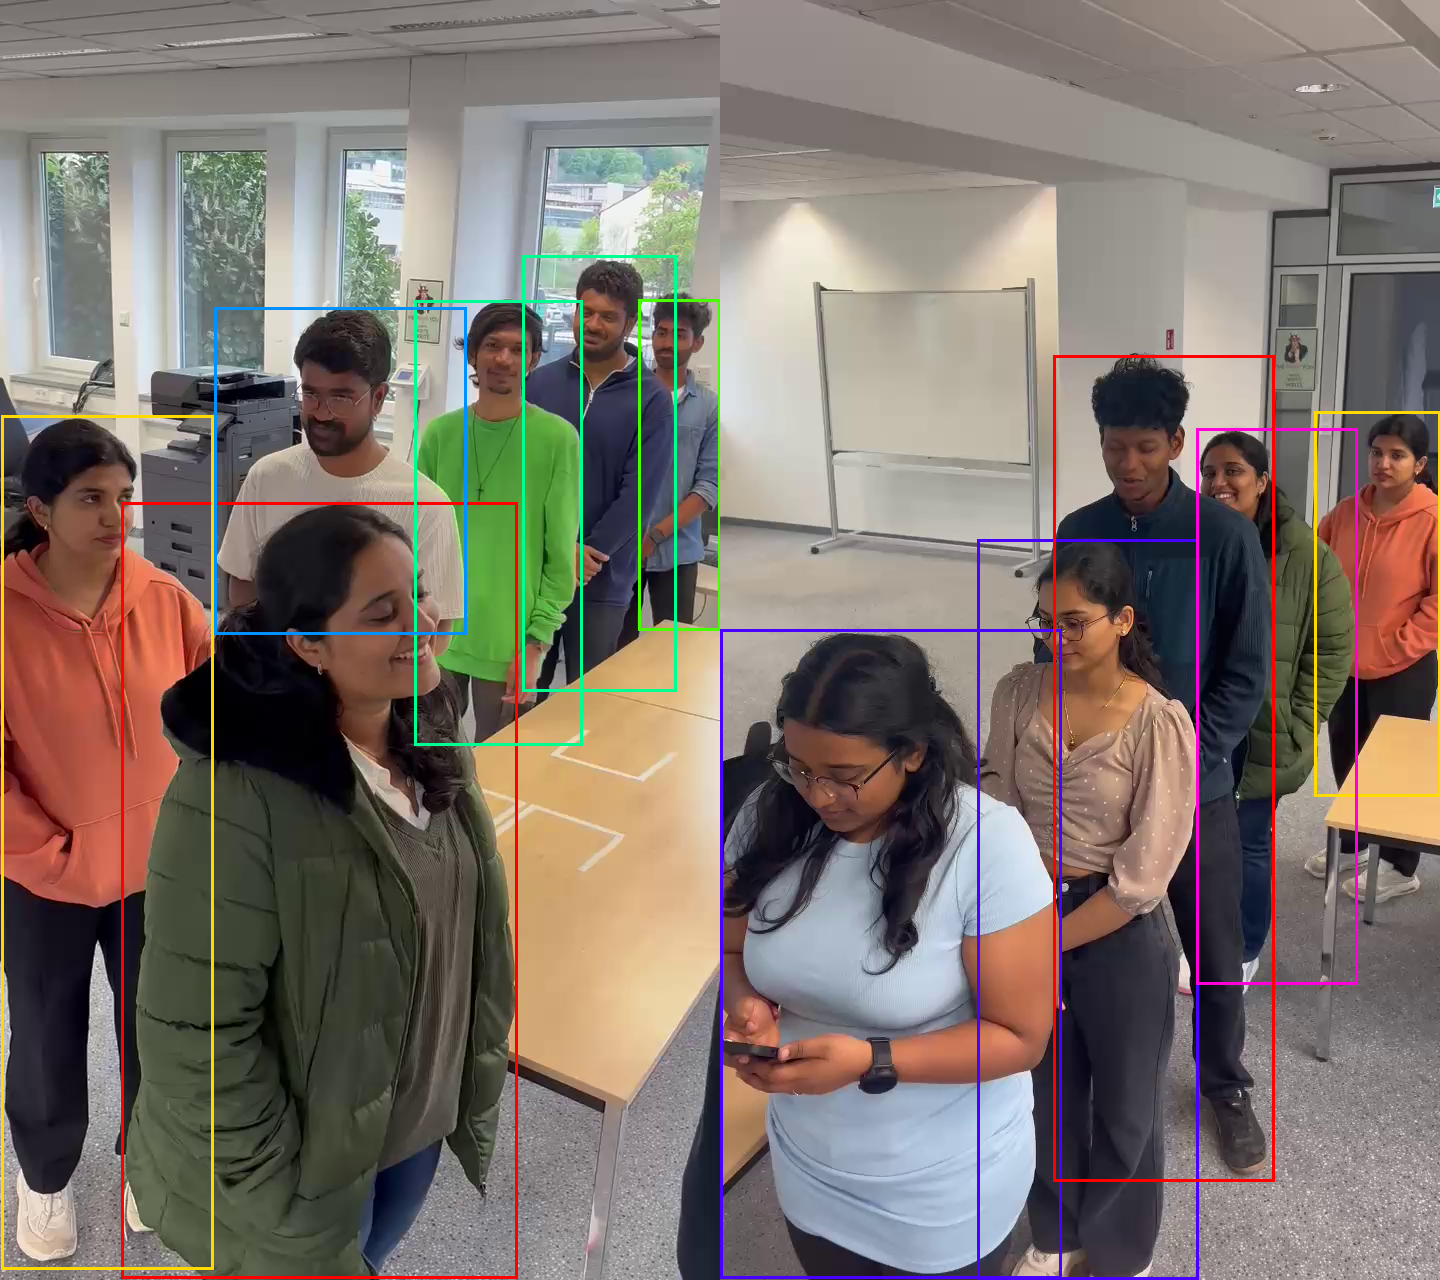

🧍 Unique people identified: 7


In [58]:
import torch
import numpy as np
from PIL import Image, ImageDraw
import torchvision.transforms as T
from ultralytics import YOLO
import torchreid
import colorsys
from IPython.display import display  # <- For inline display

# Paths to images
IMG1_PATH = r"C:\Sem_5\Portfolio1\TOY_setup\images\cam1\cam1_image_00.png"
IMG2_PATH = r"C:\Sem_5\Portfolio1\TOY_setup\images\cam2\cam1_image_00.png"
YOLO_MODEL = "yolov8s.pt"
REID_MODEL_NAME = "osnet_x1_0"
SIM_THRESHOLD = 0.9

# Load models
yolo = YOLO(YOLO_MODEL)

model = torchreid.models.build_model(
    name=REID_MODEL_NAME,
    num_classes=1000,
    loss='triplet',
    pretrained=True,
    use_gpu=torch.cuda.is_available()
)
model.eval()
if torch.cuda.is_available():
    model = model.cuda()

transform = T.Compose([
    T.Resize((720, 1280)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])

def get_embedding(cropped_pil):
    image = transform(cropped_pil).unsqueeze(0)
    if torch.cuda.is_available():
        image = image.cuda()
    with torch.no_grad():
        features = model(image)
    features = features / features.norm(dim=1, keepdim=True)  # normalize to unit vector
    return features.cpu().numpy().flatten()

def detect_people_with_boxes(image_path):
    results = yolo(image_path)[0]
    image = Image.open(image_path).convert("RGB")
    detections = []
    for box in results.boxes:
        if int(box.cls[0]) == 0:  # class 0 = person
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            crop = image.crop((x1, y1, x2, y2))
            detections.append(((x1, y1, x2, y2), crop))
    return image, detections

def generate_colors(n):
    hsv = [(i / n, 1, 1) for i in range(n)]
    return [tuple(int(c * 255) for c in colorsys.hsv_to_rgb(*col)) for col in hsv]

def show_matched_people(img1_path, img2_path, threshold=SIM_THRESHOLD):
    # Step 1: Detect people in both images
    img1, dets1 = detect_people_with_boxes(img1_path)
    img2, dets2 = detect_people_with_boxes(img2_path)

    embeddings = []
    boxes = []

    # Extract embeddings
    for i, (box, crop) in enumerate(dets1):
        emb = get_embedding(crop)
        embeddings.append((emb, 'img1', i))
        boxes.append(('img1', box))

    for i, (box, crop) in enumerate(dets2):
        emb = get_embedding(crop)
        embeddings.append((emb, 'img2', i))
        boxes.append(('img2', box))

    # Step 2: Group same people
    group_ids = [-1] * len(embeddings)
    group_counter = 0

    for i in range(len(embeddings)):
        if group_ids[i] != -1:
            continue
        group_ids[i] = group_counter
        for j in range(i + 1, len(embeddings)):
            if group_ids[j] != -1:
                continue
            sim = np.dot(embeddings[i][0], embeddings[j][0]) / (
                np.linalg.norm(embeddings[i][0]) * np.linalg.norm(embeddings[j][0])
            )
            if sim > threshold:
                group_ids[j] = group_counter
        group_counter += 1

    # Step 3: Visualize results
    img1_draw = img1.copy()
    img2_draw = img2.copy()
    draw1 = ImageDraw.Draw(img1_draw)
    draw2 = ImageDraw.Draw(img2_draw)
    colors = generate_colors(group_counter)

    for idx, gid in enumerate(group_ids):
        img_tag, box = boxes[idx]
        color = colors[gid]
        if img_tag == 'img1':
            draw1.rectangle(box, outline=color, width=3)
        else:
            draw2.rectangle(box, outline=color, width=3)

    # Concatenate both images side by side
    total_width = img1_draw.width + img2_draw.width
    max_height = max(img1_draw.height, img2_draw.height)
    combined = Image.new("RGB", (total_width, max_height))
    combined.paste(img1_draw, (0, 0))
    combined.paste(img2_draw, (img1_draw.width, 0))

    display(combined)  # ✅ Show inline in Jupyter
    print(f"🧍 Unique people identified: {group_counter}")

# Run
show_matched_people(IMG1_PATH, IMG2_PATH)


Successfully loaded imagenet pretrained weights from "C:\Users\korin/.cache\torch\checkpoints\osnet_x1_0_imagenet.pth"

image 1/1 C:\Sem_5\Portfolio1\TOY_setup\images\cam1\cam1_image_00.png: 640x384 6 persons, 90.6ms
Speed: 10.4ms preprocess, 90.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 C:\Sem_5\Portfolio1\TOY_setup\images\cam2\cam1_image_00.png: 640x384 5 persons, 2 dining tables, 1 cell phone, 87.3ms
Speed: 6.1ms preprocess, 87.3ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 384)


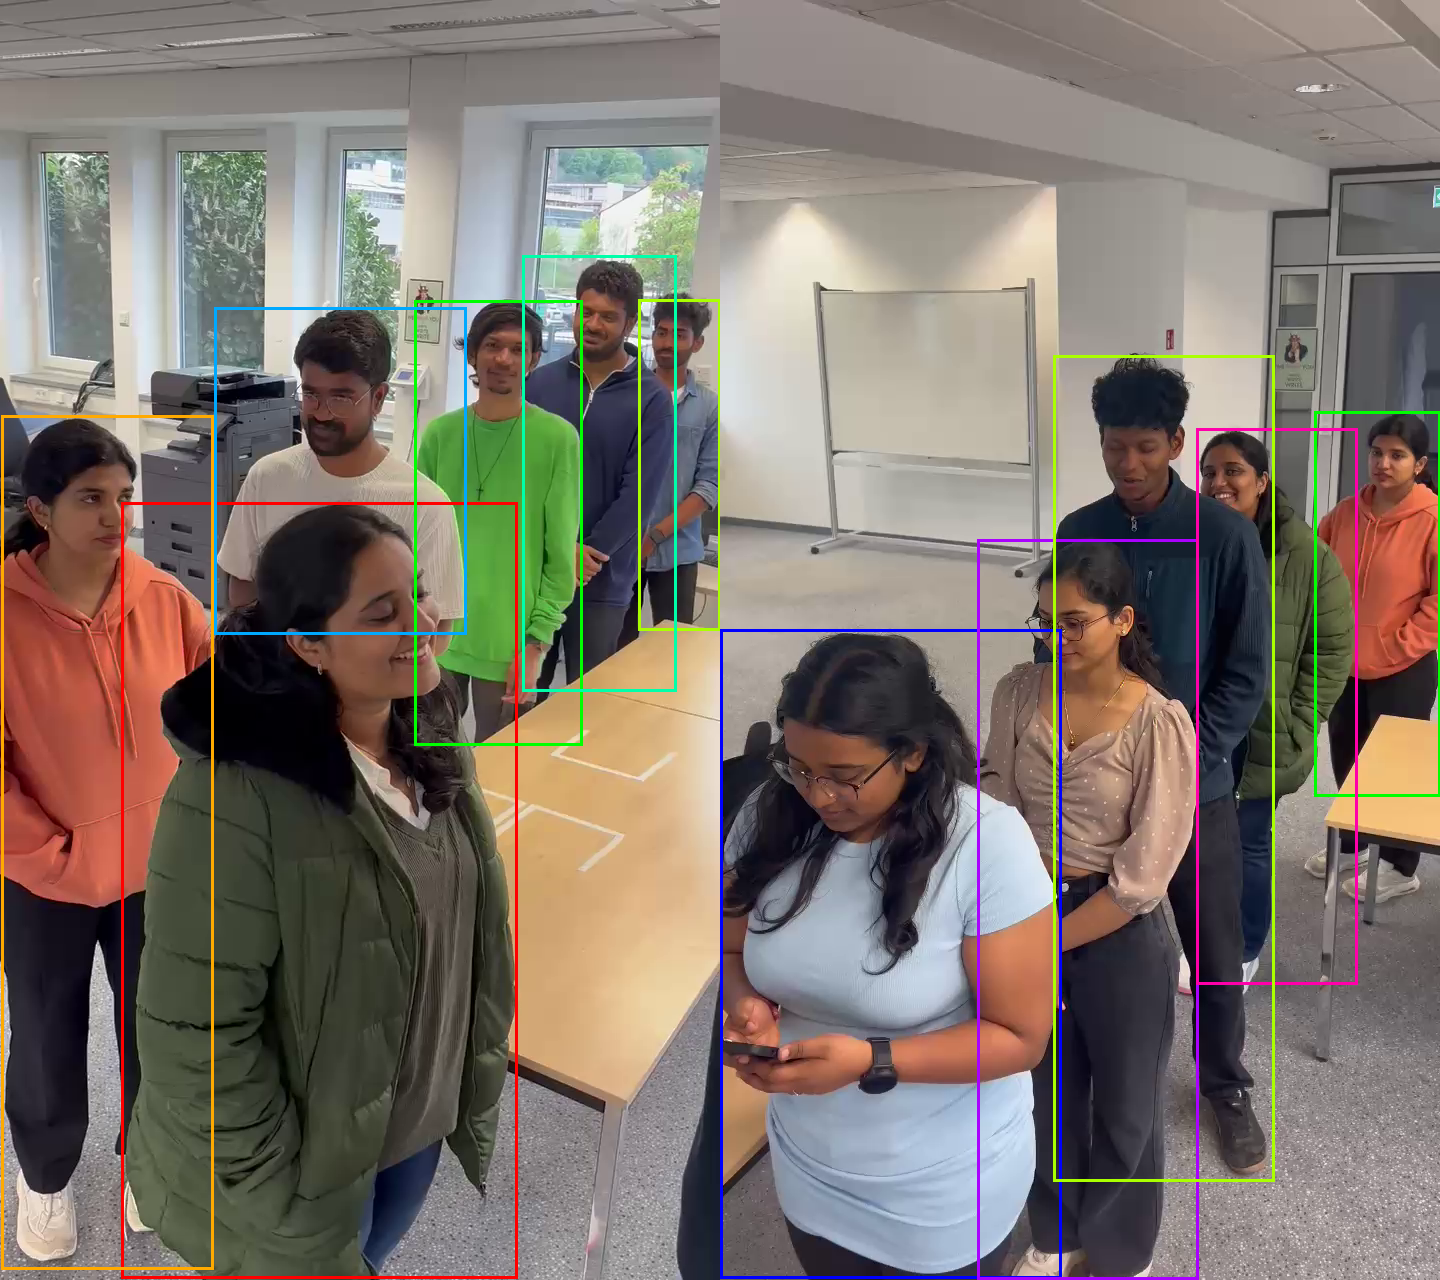

🧍 Unique people identified: 9


In [63]:
import torch
import numpy as np
from PIL import Image, ImageDraw
import torchvision.transforms as T
from ultralytics import YOLO
import torchreid
import colorsys
from IPython.display import display  # For inline display

# Paths to images
IMG1_PATH = r"C:\Sem_5\Portfolio1\TOY_setup\images\cam1\cam1_image_00.png"
IMG2_PATH = r"C:\Sem_5\Portfolio1\TOY_setup\images\cam2\cam1_image_00.png"
YOLO_MODEL = "yolov8s.pt"
REID_MODEL_NAME = "osnet_x1_0"
SIM_THRESHOLD = 0.7 # Reasonable threshold for good ReID models

# Load models
yolo = YOLO(YOLO_MODEL)

model = torchreid.models.build_model(
    name=REID_MODEL_NAME,
    num_classes=1000,
    loss='triplet',
    pretrained=True,
    use_gpu=torch.cuda.is_available()
)
model.eval()
if torch.cuda.is_available():
    model = model.cuda()

# Correct resizing for ReID
transform = T.Compose([
    T.Resize((256, 128)),   # Correct: 256 height × 128 width
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])

def get_embedding(cropped_pil):
    image = transform(cropped_pil).unsqueeze(0)
    if torch.cuda.is_available():
        image = image.cuda()
    with torch.no_grad():
        features = model(image)
    features = features / features.norm(dim=1, keepdim=True)  # normalize to unit vector
    return features.cpu().numpy().flatten()

def detect_people_with_boxes(image_path):
    results = yolo(image_path)[0]
    image = Image.open(image_path).convert("RGB")
    detections = []
    for box in results.boxes:
        if int(box.cls[0]) == 0:  # class 0 = person
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            crop = image.crop((x1, y1, x2, y2))
            detections.append(((x1, y1, x2, y2), crop))
    return image, detections

def generate_colors(n):
    hsv = [(i / n, 1, 1) for i in range(n)]
    return [tuple(int(c * 255) for c in colorsys.hsv_to_rgb(*col)) for col in hsv]

def show_matched_people(img1_path, img2_path, threshold=SIM_THRESHOLD):
    # Step 1: Detect people in both images
    img1, dets1 = detect_people_with_boxes(img1_path)
    img2, dets2 = detect_people_with_boxes(img2_path)

    embeddings = []
    boxes = []
    img_tags = []

    # Extract embeddings
    for i, (box, crop) in enumerate(dets1):
        emb = get_embedding(crop)
        embeddings.append(emb)
        boxes.append(box)
        img_tags.append('img1')

    for i, (box, crop) in enumerate(dets2):
        emb = get_embedding(crop)
        embeddings.append(emb)
        boxes.append(box)
        img_tags.append('img2')

    # Step 2: Separate cam1 and cam2 embeddings
    embeddings_cam1 = [(embeddings[i], i) for i in range(len(embeddings)) if img_tags[i] == 'img1']
    embeddings_cam2 = [(embeddings[i], i) for i in range(len(embeddings)) if img_tags[i] == 'img2']

    group_ids = [-1] * len(embeddings)
    group_counter = 0

    # Step 3: Match ONLY across cameras
    for emb1, idx1 in embeddings_cam1:
        best_match = None
        best_sim = -1
        for emb2, idx2 in embeddings_cam2:
            sim = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
            if sim > best_sim:
                best_sim = sim
                best_match = idx2
        if best_sim > threshold:
            group_ids[idx1] = group_counter
            group_ids[best_match] = group_counter
            group_counter += 1
        else:
            group_ids[idx1] = group_counter
            group_counter += 1

    # Assign unmatched cam2 people new groups
    for _, idx2 in embeddings_cam2:
        if group_ids[idx2] == -1:
            group_ids[idx2] = group_counter
            group_counter += 1

    # Step 4: Visualize results
    img1_draw = img1.copy()
    img2_draw = img2.copy()
    draw1 = ImageDraw.Draw(img1_draw)
    draw2 = ImageDraw.Draw(img2_draw)
    colors = generate_colors(group_counter)

    for idx, gid in enumerate(group_ids):
        img_tag = img_tags[idx]
        box = boxes[idx]
        color = colors[gid]
        if img_tag == 'img1':
            draw1.rectangle(box, outline=color, width=3)
        else:
            draw2.rectangle(box, outline=color, width=3)

    # Concatenate both images side by side
    total_width = img1_draw.width + img2_draw.width
    max_height = max(img1_draw.height, img2_draw.height)
    combined = Image.new("RGB", (total_width, max_height))
    combined.paste(img1_draw, (0, 0))
    combined.paste(img2_draw, (img1_draw.width, 0))

    display(combined)  # ✅ Show inline in Jupyter
    print(f"🧍 Unique people identified: {group_counter}")

# Run
show_matched_people(IMG1_PATH, IMG2_PATH)


-------------------------------------------------------------------------------------------------------------------------------------
### Subtask 3: Continuous Demonstration of the System As formal evaluation is difficult in this case, the client requests a qualitative demonstration using a continuous data stream. 

You may choose to: 

• process a pre-recorded video showing multiple camera angles, or 

• perform a live demo (e.g., using webcams or simulated camera input).

Your demo must meet the following requirements: 

• Detected individuals must be clearly marked with bounding boxes. 

• Bounding boxes may focus on faces or full bodies – depending on your approach. 

• The conditions of Subtask 2 (no duplicates, continuous tracking) must be fulfilled. 

----------------------------------------------------------------------------------------------------------------------------------------

In [5]:
import cv2
import torch
import torchreid
import numpy as np
import torchvision.transforms as T
from PIL import Image
from ultralytics import YOLO
import time
import colorsys

# ------------------------
# Configuration
# ------------------------
YOLO_MODEL_PATH = 'yolov8n.pt'
REID_MODEL_NAME = 'osnet_x1_0'
SIM_THRESHOLD = 0.7
CAM1_PATH = r"C:\Sem_5\Portfolio1\TOY_setup\video\cam1.mp4"
CAM2_PATH = r"C:\Sem_5\Portfolio1\TOY_setup\video\cam4.mp4"
OUTPUT_PATH = r"C:\Sem_5\Portfolio1\TOY_setup\output\reid_result_cleaned.mp4"

# ------------------------
# Load Models
# ------------------------
yolo_model = YOLO(YOLO_MODEL_PATH)

reid_model = torchreid.models.build_model(
    name=REID_MODEL_NAME,
    num_classes=0,
    pretrained=True,
    use_gpu=torch.cuda.is_available()
)
reid_model.eval()
if torch.cuda.is_available():
    reid_model = reid_model.cuda()

transform = T.Compose([
    T.Resize((512, 256)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ------------------------
# Helpers
# ------------------------
def extract_embedding(crop):
    img = Image.fromarray(crop).convert("RGB")
    img = transform(img).unsqueeze(0)
    if torch.cuda.is_available():
        img = img.cuda()
    with torch.no_grad():
        features = reid_model(img)
    return features.cpu().numpy().flatten()

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def yolo_person_detector(frame):
    boxes = []
    results = yolo_model(frame, verbose=False)[0]
    for det in results.boxes.data:
        x1, y1, x2, y2, conf, cls = det.tolist()
        if int(cls) == 0:
            boxes.append((int(x1), int(y1), int(x2), int(y2)))
    return boxes

def generate_colors(n):
    hsv = [(i / n, 1, 1) for i in range(n)]
    return [tuple(int(c * 255) for c in colorsys.hsv_to_rgb(*col)) for col in hsv]

# ------------------------
# Main Inference Pipeline
# ------------------------
def process_videos(cam1_path, cam2_path, output_path):
    cap1 = cv2.VideoCapture(cam1_path)
    cap2 = cv2.VideoCapture(cam2_path)

    if not cap1.isOpened() or not cap2.isOpened():
        print("❌ Could not open one or both video files.")
        return

    width, height = 955, 980
    fps = cap1.get(cv2.CAP_PROP_FPS)
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (2 * width, height))

    unique_people = []  # List of (embedding, person_id)
    person_id_counter = 0
    frame_num = 0

    print("🚀 Starting inference...")
    while True:
        ret1, frame1 = cap1.read()
        ret2, frame2 = cap2.read()

        if not ret1 or not ret2:
            print("✅ Video processing complete.")
            break

        frame1 = cv2.resize(frame1, (width, height))
        frame2 = cv2.resize(frame2, (width, height))

        start = time.time()

        for cam_id, frame in enumerate([frame1, frame2]):
            boxes = yolo_person_detector(frame)
            for (x1, y1, x2, y2) in boxes:
                crop = frame[y1:y2, x1:x2]
                if crop.size == 0:
                    continue

                emb = extract_embedding(crop)

                # Compare to all known unique people
                matched_id = None
                for known_emb, pid in unique_people:
                    sim = cosine_similarity(emb, known_emb)
                    if sim > SIM_THRESHOLD:
                        matched_id = pid
                        break

                if matched_id is None:
                    matched_id = person_id_counter
                    unique_people.append((emb, matched_id))
                    person_id_counter += 1

                color = generate_colors(person_id_counter)[matched_id]
                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                cv2.putText(frame, f"Person {matched_id}", (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        # Combine frames side by side
        combined = np.hstack((frame1, frame2))

        end = time.time()
        current_fps = 1 / (end - start)

        # Overlay info
        cv2.putText(combined, f"Unique Persons: {person_id_counter}", (20, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.putText(combined, f"Inference FPS: {current_fps:.2f}", (20, 80),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)

        out.write(combined)
        cv2.imshow("Multi-Camera Person Re-ID", combined)

        frame_num += 1
        print(f"[Frame #{frame_num}] FPS: {current_fps:.2f} | Total Unique: {person_id_counter}")

        if cv2.waitKey(1) & 0xFF == ord('q'):
            print("❌ Interrupted by user.")
            break

    cap1.release()
    cap2.release()
    out.release()
    cv2.destroyAllWindows()
    print(f"🎥 Output saved to: {output_path}")

# ------------------------
# Run
# ------------------------
process_videos(CAM1_PATH, CAM2_PATH, OUTPUT_PATH)


Successfully loaded imagenet pretrained weights from "C:\Users\korin/.cache\torch\checkpoints\osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
🚀 Starting inference...
[Frame #1] FPS: 0.19 | Total Unique: 4
[Frame #2] FPS: 0.32 | Total Unique: 4
[Frame #3] FPS: 1.04 | Total Unique: 4
[Frame #4] FPS: 2.26 | Total Unique: 4
[Frame #5] FPS: 2.12 | Total Unique: 4
[Frame #6] FPS: 2.19 | Total Unique: 4
[Frame #7] FPS: 2.10 | Total Unique: 4
[Frame #8] FPS: 2.18 | Total Unique: 4
[Frame #9] FPS: 2.04 | Total Unique: 4
[Frame #10] FPS: 2.09 | Total Unique: 4
[Frame #11] FPS: 2.04 | Total Unique: 4
[Frame #12] FPS: 2.10 | Total Unique: 4
[Frame #13] FPS: 2.11 | Total Unique: 4
[Frame #14] FPS: 2.30 | Total Unique: 4
[Frame #15] FPS: 2.51 | Total Unique: 5
[Frame #16] FPS: 2.16 | Total Unique: 5
[Frame #17] FPS: 2.27 | Total Unique: 5
[Frame #18] FPS: 2.34 | Total Unique: 5
[Frame #19] FPS: 1.96 | Total 

[Frame #197] FPS: 0.47 | Total Unique: 12
[Frame #198] FPS: 0.29 | Total Unique: 12
[Frame #199] FPS: 0.55 | Total Unique: 12
[Frame #200] FPS: 0.45 | Total Unique: 12
[Frame #201] FPS: 0.54 | Total Unique: 12
[Frame #202] FPS: 0.53 | Total Unique: 12
[Frame #203] FPS: 0.51 | Total Unique: 12
[Frame #204] FPS: 0.48 | Total Unique: 12
[Frame #205] FPS: 0.29 | Total Unique: 12
[Frame #206] FPS: 0.49 | Total Unique: 12
[Frame #207] FPS: 0.44 | Total Unique: 12
[Frame #208] FPS: 0.49 | Total Unique: 12
[Frame #209] FPS: 0.40 | Total Unique: 12
[Frame #210] FPS: 0.33 | Total Unique: 13
[Frame #211] FPS: 0.55 | Total Unique: 13
[Frame #212] FPS: 0.51 | Total Unique: 13
[Frame #213] FPS: 0.52 | Total Unique: 13
[Frame #214] FPS: 0.46 | Total Unique: 13
[Frame #215] FPS: 0.42 | Total Unique: 13
[Frame #216] FPS: 0.47 | Total Unique: 13
[Frame #217] FPS: 0.46 | Total Unique: 13
[Frame #218] FPS: 0.40 | Total Unique: 13
[Frame #219] FPS: 0.45 | Total Unique: 13
[Frame #220] FPS: 0.41 | Total Uni

[Frame #393] FPS: 0.61 | Total Unique: 16
[Frame #394] FPS: 0.60 | Total Unique: 16
[Frame #395] FPS: 0.60 | Total Unique: 16
[Frame #396] FPS: 0.66 | Total Unique: 16
[Frame #397] FPS: 0.59 | Total Unique: 16
[Frame #398] FPS: 0.57 | Total Unique: 16
[Frame #399] FPS: 0.49 | Total Unique: 16
[Frame #400] FPS: 0.54 | Total Unique: 16
[Frame #401] FPS: 0.42 | Total Unique: 16
[Frame #402] FPS: 0.55 | Total Unique: 16
[Frame #403] FPS: 0.63 | Total Unique: 16
[Frame #404] FPS: 0.62 | Total Unique: 16
[Frame #405] FPS: 0.58 | Total Unique: 16
[Frame #406] FPS: 0.60 | Total Unique: 16
[Frame #407] FPS: 0.56 | Total Unique: 16
[Frame #408] FPS: 0.56 | Total Unique: 16
[Frame #409] FPS: 0.61 | Total Unique: 16
[Frame #410] FPS: 0.62 | Total Unique: 16
[Frame #411] FPS: 0.58 | Total Unique: 16
[Frame #412] FPS: 0.55 | Total Unique: 16
[Frame #413] FPS: 0.41 | Total Unique: 16
[Frame #414] FPS: 0.56 | Total Unique: 16
[Frame #415] FPS: 0.57 | Total Unique: 16
[Frame #416] FPS: 0.46 | Total Uni

[Frame #589] FPS: 0.47 | Total Unique: 19
[Frame #590] FPS: 0.25 | Total Unique: 19
[Frame #591] FPS: 0.42 | Total Unique: 19
[Frame #592] FPS: 0.49 | Total Unique: 19
[Frame #593] FPS: 0.53 | Total Unique: 19
[Frame #594] FPS: 0.46 | Total Unique: 19
[Frame #595] FPS: 0.49 | Total Unique: 19
[Frame #596] FPS: 0.39 | Total Unique: 19
[Frame #597] FPS: 0.59 | Total Unique: 19
[Frame #598] FPS: 0.47 | Total Unique: 19
[Frame #599] FPS: 0.40 | Total Unique: 19
[Frame #600] FPS: 0.55 | Total Unique: 19
[Frame #601] FPS: 0.51 | Total Unique: 19
[Frame #602] FPS: 0.50 | Total Unique: 19
[Frame #603] FPS: 0.54 | Total Unique: 19
[Frame #604] FPS: 0.56 | Total Unique: 19
[Frame #605] FPS: 0.59 | Total Unique: 19
[Frame #606] FPS: 0.55 | Total Unique: 19
[Frame #607] FPS: 0.52 | Total Unique: 19
[Frame #608] FPS: 0.61 | Total Unique: 19
[Frame #609] FPS: 0.47 | Total Unique: 19
[Frame #610] FPS: 0.55 | Total Unique: 19
[Frame #611] FPS: 0.57 | Total Unique: 19
[Frame #612] FPS: 0.52 | Total Uni

[Frame #785] FPS: 0.69 | Total Unique: 19
[Frame #786] FPS: 0.75 | Total Unique: 19
[Frame #787] FPS: 0.65 | Total Unique: 19
[Frame #788] FPS: 0.67 | Total Unique: 19
[Frame #789] FPS: 0.51 | Total Unique: 19
[Frame #790] FPS: 0.57 | Total Unique: 19
[Frame #791] FPS: 0.58 | Total Unique: 19
[Frame #792] FPS: 0.62 | Total Unique: 19
[Frame #793] FPS: 0.61 | Total Unique: 19
[Frame #794] FPS: 0.30 | Total Unique: 19
[Frame #795] FPS: 0.47 | Total Unique: 19
[Frame #796] FPS: 0.73 | Total Unique: 19
[Frame #797] FPS: 0.63 | Total Unique: 19
[Frame #798] FPS: 0.49 | Total Unique: 19
[Frame #799] FPS: 0.72 | Total Unique: 19
[Frame #800] FPS: 0.60 | Total Unique: 19
[Frame #801] FPS: 0.63 | Total Unique: 19
[Frame #802] FPS: 0.65 | Total Unique: 19
[Frame #803] FPS: 0.45 | Total Unique: 19
[Frame #804] FPS: 0.54 | Total Unique: 19
[Frame #805] FPS: 0.69 | Total Unique: 19
[Frame #806] FPS: 0.61 | Total Unique: 19
[Frame #807] FPS: 0.77 | Total Unique: 19
[Frame #808] FPS: 0.73 | Total Uni

[Frame #981] FPS: 0.69 | Total Unique: 19
[Frame #982] FPS: 0.69 | Total Unique: 19
[Frame #983] FPS: 0.79 | Total Unique: 19
[Frame #984] FPS: 0.70 | Total Unique: 19
[Frame #985] FPS: 0.69 | Total Unique: 19
[Frame #986] FPS: 0.71 | Total Unique: 19
[Frame #987] FPS: 0.68 | Total Unique: 19
[Frame #988] FPS: 0.84 | Total Unique: 19
[Frame #989] FPS: 0.82 | Total Unique: 19
[Frame #990] FPS: 0.85 | Total Unique: 19
[Frame #991] FPS: 0.82 | Total Unique: 19
[Frame #992] FPS: 0.86 | Total Unique: 19
[Frame #993] FPS: 0.89 | Total Unique: 19
[Frame #994] FPS: 0.87 | Total Unique: 19
[Frame #995] FPS: 0.64 | Total Unique: 19
[Frame #996] FPS: 0.80 | Total Unique: 19
[Frame #997] FPS: 0.87 | Total Unique: 19
[Frame #998] FPS: 0.73 | Total Unique: 19
[Frame #999] FPS: 0.76 | Total Unique: 19
[Frame #1000] FPS: 0.67 | Total Unique: 19
[Frame #1001] FPS: 0.70 | Total Unique: 19
[Frame #1002] FPS: 0.83 | Total Unique: 19
[Frame #1003] FPS: 0.69 | Total Unique: 19
[Frame #1004] FPS: 0.78 | Tota

[Frame #1172] FPS: 0.66 | Total Unique: 19
[Frame #1173] FPS: 0.57 | Total Unique: 19
[Frame #1174] FPS: 0.59 | Total Unique: 19
[Frame #1175] FPS: 0.63 | Total Unique: 19
[Frame #1176] FPS: 0.65 | Total Unique: 19
[Frame #1177] FPS: 0.58 | Total Unique: 19
[Frame #1178] FPS: 0.69 | Total Unique: 19
[Frame #1179] FPS: 0.76 | Total Unique: 19
[Frame #1180] FPS: 0.46 | Total Unique: 19
[Frame #1181] FPS: 0.67 | Total Unique: 19
[Frame #1182] FPS: 0.72 | Total Unique: 19
[Frame #1183] FPS: 0.65 | Total Unique: 19
[Frame #1184] FPS: 0.65 | Total Unique: 19
[Frame #1185] FPS: 0.72 | Total Unique: 19
[Frame #1186] FPS: 0.72 | Total Unique: 19
[Frame #1187] FPS: 0.76 | Total Unique: 19
[Frame #1188] FPS: 0.73 | Total Unique: 19
[Frame #1189] FPS: 0.58 | Total Unique: 19
[Frame #1190] FPS: 0.66 | Total Unique: 19
[Frame #1191] FPS: 0.65 | Total Unique: 19
[Frame #1192] FPS: 0.60 | Total Unique: 19
[Frame #1193] FPS: 0.51 | Total Unique: 19
[Frame #1194] FPS: 0.74 | Total Unique: 19
[Frame #119

[Frame #1363] FPS: 0.62 | Total Unique: 20
[Frame #1364] FPS: 0.73 | Total Unique: 20
[Frame #1365] FPS: 0.69 | Total Unique: 20
[Frame #1366] FPS: 0.44 | Total Unique: 20
[Frame #1367] FPS: 0.48 | Total Unique: 20
[Frame #1368] FPS: 0.66 | Total Unique: 20
[Frame #1369] FPS: 0.72 | Total Unique: 20
[Frame #1370] FPS: 0.69 | Total Unique: 20
[Frame #1371] FPS: 0.56 | Total Unique: 20
[Frame #1372] FPS: 0.53 | Total Unique: 20
[Frame #1373] FPS: 0.52 | Total Unique: 20
[Frame #1374] FPS: 0.64 | Total Unique: 20
[Frame #1375] FPS: 0.60 | Total Unique: 20
[Frame #1376] FPS: 0.60 | Total Unique: 20
[Frame #1377] FPS: 0.57 | Total Unique: 20
[Frame #1378] FPS: 0.63 | Total Unique: 20
[Frame #1379] FPS: 0.57 | Total Unique: 20
[Frame #1380] FPS: 0.53 | Total Unique: 20
[Frame #1381] FPS: 0.62 | Total Unique: 20
[Frame #1382] FPS: 0.46 | Total Unique: 20
[Frame #1383] FPS: 0.43 | Total Unique: 20
[Frame #1384] FPS: 0.51 | Total Unique: 20
[Frame #1385] FPS: 0.48 | Total Unique: 20
[Frame #138

[Frame #1554] FPS: 0.72 | Total Unique: 20
[Frame #1555] FPS: 0.69 | Total Unique: 20
[Frame #1556] FPS: 0.68 | Total Unique: 20
[Frame #1557] FPS: 0.72 | Total Unique: 20
[Frame #1558] FPS: 0.73 | Total Unique: 20
[Frame #1559] FPS: 0.70 | Total Unique: 20
[Frame #1560] FPS: 0.57 | Total Unique: 20
[Frame #1561] FPS: 0.58 | Total Unique: 20
[Frame #1562] FPS: 0.61 | Total Unique: 20
[Frame #1563] FPS: 0.54 | Total Unique: 20
[Frame #1564] FPS: 0.54 | Total Unique: 20
[Frame #1565] FPS: 0.54 | Total Unique: 20
[Frame #1566] FPS: 0.61 | Total Unique: 20
[Frame #1567] FPS: 0.53 | Total Unique: 20
[Frame #1568] FPS: 0.45 | Total Unique: 20
[Frame #1569] FPS: 0.61 | Total Unique: 20
[Frame #1570] FPS: 0.66 | Total Unique: 20
[Frame #1571] FPS: 0.56 | Total Unique: 20
[Frame #1572] FPS: 0.69 | Total Unique: 20
[Frame #1573] FPS: 0.62 | Total Unique: 20
[Frame #1574] FPS: 0.64 | Total Unique: 20
[Frame #1575] FPS: 0.58 | Total Unique: 20
[Frame #1576] FPS: 0.66 | Total Unique: 20
[Frame #157

[Frame #1745] FPS: 0.57 | Total Unique: 22
[Frame #1746] FPS: 0.51 | Total Unique: 22
[Frame #1747] FPS: 0.67 | Total Unique: 22
[Frame #1748] FPS: 0.52 | Total Unique: 22
[Frame #1749] FPS: 0.36 | Total Unique: 22
[Frame #1750] FPS: 0.61 | Total Unique: 22
[Frame #1751] FPS: 0.52 | Total Unique: 22
[Frame #1752] FPS: 0.56 | Total Unique: 22
[Frame #1753] FPS: 0.50 | Total Unique: 22
[Frame #1754] FPS: 0.42 | Total Unique: 22
[Frame #1755] FPS: 0.48 | Total Unique: 22
[Frame #1756] FPS: 0.63 | Total Unique: 22
[Frame #1757] FPS: 0.63 | Total Unique: 22
[Frame #1758] FPS: 0.61 | Total Unique: 22
[Frame #1759] FPS: 0.63 | Total Unique: 22
[Frame #1760] FPS: 0.67 | Total Unique: 22
[Frame #1761] FPS: 0.61 | Total Unique: 22
[Frame #1762] FPS: 0.60 | Total Unique: 22
[Frame #1763] FPS: 0.74 | Total Unique: 22
[Frame #1764] FPS: 0.60 | Total Unique: 22
[Frame #1765] FPS: 0.65 | Total Unique: 22
[Frame #1766] FPS: 0.63 | Total Unique: 22
[Frame #1767] FPS: 0.60 | Total Unique: 22
[Frame #176

[Frame #1936] FPS: 0.77 | Total Unique: 22
[Frame #1937] FPS: 0.67 | Total Unique: 22
[Frame #1938] FPS: 0.70 | Total Unique: 22
[Frame #1939] FPS: 0.65 | Total Unique: 22
[Frame #1940] FPS: 0.58 | Total Unique: 22
[Frame #1941] FPS: 0.55 | Total Unique: 22
[Frame #1942] FPS: 0.66 | Total Unique: 22
[Frame #1943] FPS: 0.67 | Total Unique: 23
[Frame #1944] FPS: 0.63 | Total Unique: 23
[Frame #1945] FPS: 0.62 | Total Unique: 23
[Frame #1946] FPS: 0.56 | Total Unique: 23
[Frame #1947] FPS: 0.64 | Total Unique: 23
[Frame #1948] FPS: 0.74 | Total Unique: 23
[Frame #1949] FPS: 0.66 | Total Unique: 23
[Frame #1950] FPS: 0.75 | Total Unique: 23
[Frame #1951] FPS: 0.72 | Total Unique: 23
[Frame #1952] FPS: 0.57 | Total Unique: 23
[Frame #1953] FPS: 0.49 | Total Unique: 23
[Frame #1954] FPS: 0.76 | Total Unique: 23
[Frame #1955] FPS: 0.47 | Total Unique: 23
[Frame #1956] FPS: 0.75 | Total Unique: 23
[Frame #1957] FPS: 0.49 | Total Unique: 23
[Frame #1958] FPS: 0.44 | Total Unique: 23
[Frame #195

[Frame #2127] FPS: 0.65 | Total Unique: 25
[Frame #2128] FPS: 0.64 | Total Unique: 25
[Frame #2129] FPS: 0.51 | Total Unique: 25
[Frame #2130] FPS: 0.59 | Total Unique: 25
[Frame #2131] FPS: 0.18 | Total Unique: 25
[Frame #2132] FPS: 0.29 | Total Unique: 25
[Frame #2133] FPS: 0.36 | Total Unique: 25
[Frame #2134] FPS: 0.33 | Total Unique: 25
[Frame #2135] FPS: 0.00 | Total Unique: 25
[Frame #2136] FPS: 0.74 | Total Unique: 25
[Frame #2137] FPS: 1.44 | Total Unique: 25
[Frame #2138] FPS: 2.39 | Total Unique: 25
[Frame #2139] FPS: 2.48 | Total Unique: 25
[Frame #2140] FPS: 1.07 | Total Unique: 25
[Frame #2141] FPS: 0.00 | Total Unique: 25
[Frame #2142] FPS: 0.07 | Total Unique: 25
[Frame #2143] FPS: 0.27 | Total Unique: 25
[Frame #2144] FPS: 0.12 | Total Unique: 25
[Frame #2145] FPS: 0.29 | Total Unique: 25
[Frame #2146] FPS: 0.46 | Total Unique: 25
[Frame #2147] FPS: 0.43 | Total Unique: 25
[Frame #2148] FPS: 0.48 | Total Unique: 25
[Frame #2149] FPS: 0.32 | Total Unique: 25
[Frame #215

[Frame #2318] FPS: 0.25 | Total Unique: 26
[Frame #2319] FPS: 0.21 | Total Unique: 26
[Frame #2320] FPS: 0.21 | Total Unique: 26
[Frame #2321] FPS: 0.22 | Total Unique: 26
[Frame #2322] FPS: 0.25 | Total Unique: 26
[Frame #2323] FPS: 0.21 | Total Unique: 26
[Frame #2324] FPS: 0.24 | Total Unique: 26
[Frame #2325] FPS: 0.25 | Total Unique: 26
[Frame #2326] FPS: 0.26 | Total Unique: 26
[Frame #2327] FPS: 0.22 | Total Unique: 26
[Frame #2328] FPS: 0.20 | Total Unique: 26
[Frame #2329] FPS: 0.21 | Total Unique: 26
[Frame #2330] FPS: 0.17 | Total Unique: 26
[Frame #2331] FPS: 0.20 | Total Unique: 26
[Frame #2332] FPS: 1.32 | Total Unique: 26
[Frame #2333] FPS: 1.70 | Total Unique: 26
[Frame #2334] FPS: 1.45 | Total Unique: 26
[Frame #2335] FPS: 1.45 | Total Unique: 26
[Frame #2336] FPS: 1.27 | Total Unique: 26
[Frame #2337] FPS: 1.56 | Total Unique: 26
[Frame #2338] FPS: 1.52 | Total Unique: 26
[Frame #2339] FPS: 1.47 | Total Unique: 26
[Frame #2340] FPS: 1.86 | Total Unique: 26
[Frame #234

[Frame #2509] FPS: 1.32 | Total Unique: 26
[Frame #2510] FPS: 1.29 | Total Unique: 26
[Frame #2511] FPS: 1.28 | Total Unique: 26
[Frame #2512] FPS: 1.10 | Total Unique: 26
[Frame #2513] FPS: 1.30 | Total Unique: 26
[Frame #2514] FPS: 1.31 | Total Unique: 26
[Frame #2515] FPS: 1.17 | Total Unique: 26
[Frame #2516] FPS: 1.37 | Total Unique: 26
[Frame #2517] FPS: 1.22 | Total Unique: 26
[Frame #2518] FPS: 1.20 | Total Unique: 26
[Frame #2519] FPS: 1.18 | Total Unique: 26
[Frame #2520] FPS: 1.25 | Total Unique: 26
[Frame #2521] FPS: 1.34 | Total Unique: 26
[Frame #2522] FPS: 1.42 | Total Unique: 26
[Frame #2523] FPS: 1.33 | Total Unique: 26
[Frame #2524] FPS: 1.27 | Total Unique: 26
[Frame #2525] FPS: 1.32 | Total Unique: 26
[Frame #2526] FPS: 1.28 | Total Unique: 26
[Frame #2527] FPS: 1.33 | Total Unique: 26
[Frame #2528] FPS: 1.09 | Total Unique: 26
[Frame #2529] FPS: 1.10 | Total Unique: 26
[Frame #2530] FPS: 1.14 | Total Unique: 26
[Frame #2531] FPS: 1.24 | Total Unique: 26
[Frame #253

[Frame #2700] FPS: 1.28 | Total Unique: 26
[Frame #2701] FPS: 1.33 | Total Unique: 26
[Frame #2702] FPS: 1.45 | Total Unique: 26
[Frame #2703] FPS: 1.25 | Total Unique: 26
[Frame #2704] FPS: 1.41 | Total Unique: 26
[Frame #2705] FPS: 1.28 | Total Unique: 26
[Frame #2706] FPS: 1.33 | Total Unique: 26
[Frame #2707] FPS: 1.58 | Total Unique: 26
[Frame #2708] FPS: 1.58 | Total Unique: 26
[Frame #2709] FPS: 1.36 | Total Unique: 26
[Frame #2710] FPS: 1.21 | Total Unique: 26
[Frame #2711] FPS: 1.34 | Total Unique: 26
[Frame #2712] FPS: 1.35 | Total Unique: 26
[Frame #2713] FPS: 1.10 | Total Unique: 26
[Frame #2714] FPS: 1.30 | Total Unique: 26
[Frame #2715] FPS: 1.45 | Total Unique: 26
[Frame #2716] FPS: 1.52 | Total Unique: 26
[Frame #2717] FPS: 1.49 | Total Unique: 26
[Frame #2718] FPS: 1.38 | Total Unique: 26
[Frame #2719] FPS: 1.45 | Total Unique: 26
[Frame #2720] FPS: 1.39 | Total Unique: 26
[Frame #2721] FPS: 1.65 | Total Unique: 26
[Frame #2722] FPS: 1.52 | Total Unique: 26
[Frame #272

[Frame #2891] FPS: 1.50 | Total Unique: 26
[Frame #2892] FPS: 1.48 | Total Unique: 26
[Frame #2893] FPS: 1.56 | Total Unique: 26
[Frame #2894] FPS: 1.31 | Total Unique: 26
[Frame #2895] FPS: 1.40 | Total Unique: 26
[Frame #2896] FPS: 1.25 | Total Unique: 26
[Frame #2897] FPS: 1.18 | Total Unique: 26
[Frame #2898] FPS: 1.21 | Total Unique: 26
[Frame #2899] FPS: 1.35 | Total Unique: 26
[Frame #2900] FPS: 1.26 | Total Unique: 26
[Frame #2901] FPS: 1.29 | Total Unique: 26
[Frame #2902] FPS: 1.34 | Total Unique: 26
[Frame #2903] FPS: 1.26 | Total Unique: 26
[Frame #2904] FPS: 1.29 | Total Unique: 26
[Frame #2905] FPS: 1.20 | Total Unique: 26
[Frame #2906] FPS: 1.21 | Total Unique: 26
[Frame #2907] FPS: 1.10 | Total Unique: 26
[Frame #2908] FPS: 1.11 | Total Unique: 26
[Frame #2909] FPS: 1.07 | Total Unique: 26
[Frame #2910] FPS: 1.18 | Total Unique: 26
[Frame #2911] FPS: 1.25 | Total Unique: 26
[Frame #2912] FPS: 1.11 | Total Unique: 26
[Frame #2913] FPS: 1.14 | Total Unique: 26
[Frame #291

[Frame #3082] FPS: 1.17 | Total Unique: 28
[Frame #3083] FPS: 1.07 | Total Unique: 28
[Frame #3084] FPS: 1.29 | Total Unique: 28
[Frame #3085] FPS: 1.16 | Total Unique: 28
[Frame #3086] FPS: 1.06 | Total Unique: 28
[Frame #3087] FPS: 1.29 | Total Unique: 28
[Frame #3088] FPS: 1.46 | Total Unique: 28
[Frame #3089] FPS: 1.30 | Total Unique: 28
[Frame #3090] FPS: 1.18 | Total Unique: 28
[Frame #3091] FPS: 1.50 | Total Unique: 28
[Frame #3092] FPS: 1.04 | Total Unique: 28
[Frame #3093] FPS: 1.36 | Total Unique: 28
[Frame #3094] FPS: 1.28 | Total Unique: 28
[Frame #3095] FPS: 1.09 | Total Unique: 28
[Frame #3096] FPS: 1.39 | Total Unique: 28
[Frame #3097] FPS: 1.33 | Total Unique: 28
[Frame #3098] FPS: 0.55 | Total Unique: 28
[Frame #3099] FPS: 0.18 | Total Unique: 28
[Frame #3100] FPS: 0.20 | Total Unique: 28
[Frame #3101] FPS: 0.24 | Total Unique: 28
[Frame #3102] FPS: 0.21 | Total Unique: 28
[Frame #3103] FPS: 0.20 | Total Unique: 28
[Frame #3104] FPS: 0.21 | Total Unique: 28
[Frame #310

[Frame #3273] FPS: 0.13 | Total Unique: 29
[Frame #3274] FPS: 0.17 | Total Unique: 29
[Frame #3275] FPS: 0.18 | Total Unique: 29
[Frame #3276] FPS: 0.17 | Total Unique: 29
[Frame #3277] FPS: 0.18 | Total Unique: 29
[Frame #3278] FPS: 1.08 | Total Unique: 29
[Frame #3279] FPS: 1.21 | Total Unique: 29
[Frame #3280] FPS: 1.17 | Total Unique: 29
[Frame #3281] FPS: 1.26 | Total Unique: 29
[Frame #3282] FPS: 1.22 | Total Unique: 29
[Frame #3283] FPS: 1.21 | Total Unique: 29
[Frame #3284] FPS: 1.25 | Total Unique: 29
[Frame #3285] FPS: 1.33 | Total Unique: 29
[Frame #3286] FPS: 1.25 | Total Unique: 29
[Frame #3287] FPS: 1.31 | Total Unique: 29
[Frame #3288] FPS: 1.29 | Total Unique: 29
[Frame #3289] FPS: 1.28 | Total Unique: 29
[Frame #3290] FPS: 1.38 | Total Unique: 29
[Frame #3291] FPS: 1.24 | Total Unique: 29
[Frame #3292] FPS: 1.01 | Total Unique: 29
[Frame #3293] FPS: 1.12 | Total Unique: 29
[Frame #3294] FPS: 1.00 | Total Unique: 29
[Frame #3295] FPS: 1.17 | Total Unique: 29
[Frame #329

[Frame #3464] FPS: 1.39 | Total Unique: 29
[Frame #3465] FPS: 1.27 | Total Unique: 29
[Frame #3466] FPS: 1.14 | Total Unique: 29
[Frame #3467] FPS: 1.24 | Total Unique: 29
[Frame #3468] FPS: 1.18 | Total Unique: 29
[Frame #3469] FPS: 1.22 | Total Unique: 29
[Frame #3470] FPS: 1.19 | Total Unique: 29
[Frame #3471] FPS: 1.11 | Total Unique: 29
[Frame #3472] FPS: 1.08 | Total Unique: 29
[Frame #3473] FPS: 1.19 | Total Unique: 29
[Frame #3474] FPS: 1.44 | Total Unique: 29
[Frame #3475] FPS: 1.36 | Total Unique: 29
[Frame #3476] FPS: 1.41 | Total Unique: 29
[Frame #3477] FPS: 1.41 | Total Unique: 29
[Frame #3478] FPS: 1.30 | Total Unique: 29
[Frame #3479] FPS: 1.28 | Total Unique: 29
[Frame #3480] FPS: 1.17 | Total Unique: 29
[Frame #3481] FPS: 1.15 | Total Unique: 29
[Frame #3482] FPS: 1.08 | Total Unique: 29
[Frame #3483] FPS: 1.03 | Total Unique: 29
[Frame #3484] FPS: 1.25 | Total Unique: 29
[Frame #3485] FPS: 1.24 | Total Unique: 29
[Frame #3486] FPS: 1.21 | Total Unique: 29
[Frame #348

KeyboardInterrupt: 

----------------------------------------------------------------------------------------------------------------------------
### (Bonus) Subtask 4: Estimate Waiting Time (optional, up to 3 points) 

Optionally, you may extend your implementation to provide a basic waiting time estimation for each person in line. 

Possible approach: • Track the time it takes for individuals to disappear from the scene (i.e., reach the ride). 

• Use this to estimate waiting time for others in the queue and display it within each bounding box. 

You may assume a continuous flow of visitors without batching (e.g., roller coaster boarding behavior can be ignored)

------------------------------------------------------------------------------------------------------------------------------

In [ ]:
import cv2
import torch
import torchreid
import numpy as np
import torchvision.transforms as T
from PIL import Image
from ultralytics import YOLO
import time
import colorsys

# ------------------------
# Configuration
# ------------------------
YOLO_MODEL_PATH = 'yolov8n.pt'
REID_MODEL_NAME = 'osnet_x1_0'
SIM_THRESHOLD = 0.9
CAM1_PATH = r"C:\Sem_5\Portfolio1\TOY_setup\video\cam1.mp4"
CAM2_PATH = r"C:\Sem_5\Portfolio1\TOY_setup\video\cam4.mp4"
OUTPUT_PATH = r"C:\Sem_5\Portfolio1\TOY_setup\output\reid_result_cleaned.mp4"

# ------------------------
# Load Models
# ------------------------
yolo_model = YOLO(YOLO_MODEL_PATH)
reid_model = torchreid.models.build_model(
    name=REID_MODEL_NAME,
    num_classes=0,
    pretrained=True,
    use_gpu=torch.cuda.is_available()
)
reid_model.eval()
if torch.cuda.is_available():
    reid_model = reid_model.cuda()

transform = T.Compose([
    T.Resize((512, 256)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ------------------------
# Helpers
# ------------------------
def extract_embedding(crop):
    img = Image.fromarray(crop).convert("RGB")
    img = transform(img).unsqueeze(0)
    if torch.cuda.is_available():
        img = img.cuda()
    with torch.no_grad():
        features = reid_model(img)
    return features.cpu().numpy().flatten()

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def yolo_person_detector(frame):
    boxes = []
    results = yolo_model(frame, verbose=False)[0]
    for det in results.boxes.data:
        x1, y1, x2, y2, conf, cls = det.tolist()
        if int(cls) == 0:
            boxes.append((int(x1), int(y1), int(x2), int(y2)))
    return boxes

def generate_colors(n):
    hsv = [(i / n, 1, 1) for i in range(n)]
    return [tuple(int(c * 255) for c in colorsys.hsv_to_rgb(*col)) for col in hsv]

# ------------------------
# Main Function
# ------------------------
def process_videos(cam1_path, cam2_path, output_path):
    cap1 = cv2.VideoCapture(cam1_path)
    cap2 = cv2.VideoCapture(cam2_path)
    if not cap1.isOpened() or not cap2.isOpened():
        print("❌ Could not open one or both video files.")
        return

    width, height = 955, 980
    fps = cap1.get(cv2.CAP_PROP_FPS)
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (2 * width, height))

    unique_people = []  # List of (embedding, person_id)
    person_id_counter = 0
    first_seen_frame = {}  # person_id -> frame number in cam1
    frame_num = 0

    print("🚀 Starting inference...")
    while True:
        ret1, frame1 = cap1.read()
        ret2, frame2 = cap2.read()
        if not ret1 or not ret2:
            break

        frame1 = cv2.resize(frame1, (width, height))
        frame2 = cv2.resize(frame2, (width, height))

        start = time.time()

        for cam_id, frame in enumerate([frame1, frame2]):
            boxes = yolo_person_detector(frame)
            for (x1, y1, x2, y2) in boxes:
                crop = frame[y1:y2, x1:x2]
                if crop.size == 0:
                    continue
                emb = extract_embedding(crop)

                matched_id = None
                for known_emb, pid in unique_people:
                    if cosine_similarity(emb, known_emb) > SIM_THRESHOLD:
                        matched_id = pid
                        break

                if matched_id is None:
                    matched_id = person_id_counter
                    unique_people.append((emb, matched_id))
                    if cam_id == 0:  # Only track entry in cam1
                        first_seen_frame[matched_id] = frame_num
                    person_id_counter += 1

                color = generate_colors(person_id_counter)[matched_id]
                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                cv2.putText(frame, f"Person {matched_id}", (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

                if cam_id == 0 and matched_id in first_seen_frame:
                    wait_time = (frame_num - first_seen_frame[matched_id]) / fps
                    cv2.putText(frame, f"Wait: {wait_time:.1f}s", (x1, y2 + 20),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.55, color, 2)

        combined = np.hstack((frame1, frame2))
        current_fps = 1 / (time.time() - start)
        cv2.putText(combined, f"Unique Persons: {person_id_counter}", (20, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.putText(combined, f"Inference FPS: {current_fps:.2f}", (20, 80),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)

        out.write(combined)
        cv2.imshow("Multi-Camera Person Re-ID with Waiting Time", combined)

        frame_num += 1
        print(f"[Frame {frame_num}] FPS: {current_fps:.2f} | Total Unique: {person_id_counter}")

        if cv2.waitKey(1) & 0xFF == ord('q'):
            print("❌ Interrupted by user.")
            break

    cap1.release()
    cap2.release()
    out.release()
    cv2.destroyAllWindows()
    print(f"🎥 Output saved to: {output_path}")

# ------------------------
# Execute
# ------------------------
process_videos(CAM1_PATH, CAM2_PATH, OUTPUT_PATH)